# Tutorial
*Last updated: Jan 27, 2020*

`clonosGP` is a software that lets you identify clusters of mutations using next-generation sequencing data from tumour samples. It can be used with either single or multiple samples from a single patient and, in the latter case, with either cross-sectional or longitudinal data. What makes `clonosGP` special is that, in the case of longitudinal samples, it can take into account the time of sample collection (if it is available). This information is used for reconstructing the temporal profile of mutation clusters *continusously*, i.e. at and between the timepoints at which samples were collected. The mathematical details of the statistical methodology are given in the associated [paper](https://doi.org/10.1101/2020.01.20.913236). In brief, we combine two core methodologies in non-parametric Bayesian statistics, *Dirichlet Process Mixture Models* and *Gaussian Process Latent Variable Models*. This means that 1) we do not need to pre-specify the number of clusters in the data (these are estimated along with other model parameters) and 2) we do not need to pre-specify the functional form of the time-dependence of mutation clusters (we merely need to specify how smooth this dependence is). Below, I will show you how to apply `clonsoGP` on various scenarios and the various adjustable parameters you have at your disposal.

But first, let's import some necessary libraries:

In [1]:
import logging as log
import warnings as warn
import pandas as pnd
import pymc3 as pmc
import clonosGP as cln

log.getLogger('theano').setLevel(log.ERROR)             ## supress annoying warnings ...
warn.filterwarnings("ignore", category=FutureWarning)   ## from Theano

`Theano` is, unfortunatelly, not being developed anymore. If you're curious about the "annoying messages", restart the kernel of this notebook and reload the above packages, with the last two lines commented out.    

## Processing a single sample

It may be the case that you have sequenced only a single tumour sample from a particular patient. Let's see an example:

In [2]:
DATA = pnd.read_csv('data/CH1001_CLL.csv')
DATA

,SAMPLEID,PHASE,MUTID,r,R,CNn,CNt,LOH,DISRUPTIVE,PURITY
0,CH1001,CLL,chr1:1737942:A:G,36.0,107,2,2,False,True,0.8
1,CH1001,CLL,chr1:100357180:G:T,38.0,123,2,2,False,True,0.8
2,CH1001,CLL,chr1:111957592:A:G,10.0,60,2,2,False,True,0.8
3,CH1001,CLL,chr2:10098984:A:T,46.0,93,2,2,False,True,0.8
4,CH1001,CLL,chr2:37302699:G:A,13.0,113,2,2,False,True,0.8
...,...,...,...,...,...,...,...,...,...,...
995,CH1001,CLL,chr3:2018099:G:C,42.0,117,2,2,False,NaN,0.8
996,CH1001,CLL,chr11:93351591:T:G,34.0,99,2,2,False,NaN,0.8
997,CH1001,CLL,chr6:55152563:A:T,45.0,108,2,2,False,NaN,0.8
998,CH1001,CLL,chr15:71550454:T:A,28.0,102,2,2,False,NaN,0.8


The above are somatic mutations identified through whole genome sequencing (WGS) of a blood sample from a patient with Richter's syndrome, a rare but devastating complication of *chronic lymphocytic leukaemia* (CLL). The data are stored in long format, meaning that each row gives information for a single mutation in a single sample. The minimum set of columns that must be present are `SAMPLEID`, `MUTID`, `r` and `R`, where `r` is the number of reads harbouring the mutation and `R` is the sum of `r` plus the number of reads harbouring the reference allele. Since we consider only a single sample, `SAMPLEID` is the same for all rows. We also have the following columns:

1. `PURITY`: the purity of the sample. If missing, it is assumed equal to 1 (i.e. 100%). 
2. `CNn`: the local copy number at the locus of each mutation in the germline. If missing, it is assumed equal to 2.
3. `CNt`: the local copy number at the locus of each mutation in the sample. If missing, it is assumed equal to 2.

If available, you should also provide the number of chromosomes harbouring each mutation in the sample, under the column with name `CNm`. Here, we do not have this info, so `CNm` will be computed from the data. 

Any additional columns (e.g. `LOH`, `DISRUPTIVE`, `PHASE`) will be ignored.

Now, you are ready to run `clonoGP`, as follows:

In [3]:
pmc.tt_rng(42)    ## for reproducibility
RES = cln.infer(DATA, pymc3_args={'niters': int(10e3)}) ## Run inference for 10K iterations

INFO:clonosGP:No CNm column in the data. Multiplicity values will be approximated.
Average Loss = 3,573.8: 100%|██████████| 10000/10000 [00:50<00:00, 199.36it/s]
Finished [100%]: Average Loss = 3,573.8
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 3,573.8
INFO:clonosGP:Calculating posterior cluster weights and centres.
INFO:clonosGP:Calculating posterior CCF values.
INFO:clonosGP:Calculating posterior predictive distribution.
INFO:clonosGP:Calculating dispersion(s).
INFO:clonosGP:Finished.


The first time you try the above, it may take some time for the inference algorithm to start running, due to the statistical model being compiled in the background. We use `PyMC3` for inference, which is a great probabilistic programming language for doing Bayesian statistics. After inference has finished, you can visualise the results:   

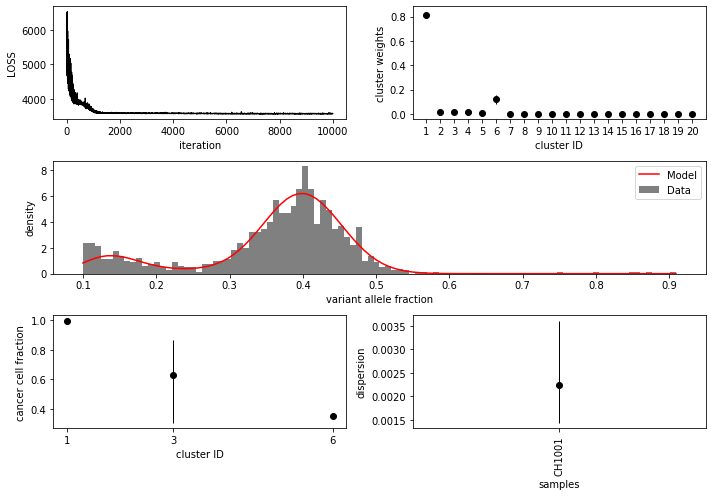

In [4]:
cln.viz.plot_summary(RES, figsize=(10, 7));

The first think you have to do is check the top-left panel and make sure that the algorithm has converged. If not, repeat the process with a larger number of iterations (parameter `niters` above). If you want, you can also try a different learning rate, e.g. `pymc3_args={'niters'=int(10e3), learning_rate=1e-3}` (the default is 1e-2).

From the top-right panel, you can see that there are two major clusters including 80% (cluster ID 1) and 15% (cluster ID 6) of the mutations. You can see these two clusters clearly in the middle panel, where the fitted model is overlayed on the data.    

In the bottom left panel, you can see the estimated *cancer cell fraction* (CCF) for each cluster (i.e. the fraction of cancer cells harbouring this cluster of mutations). The cluster with ID 1 has a CCF of 1 (so, these mutations are clonal), while cluster with ID 6 has a CCF of ~0.35 (subclonal mutations). Apparently, there is also a third cluster with ID 3 and an itermediate CCF. This cluster must contain very few mutations and this is why it has negligible weight in the top-right panel. Let's confirm this by directly examining the data (don't worry if you don't see why the following works; we 'll examine the output `RES` in more detail below):         

In [5]:
RES['data'][['MUTID', 'CLUSTERID']].groupby('CLUSTERID').count()

,MUTID
CLUSTERID,
1,845
3,3
6,152


Indeed, clusters 1 and 6 include 845 and 152 mutations, respectively, while cluster 3 includes only 3 mutations. Most likely, these mutations cannot be assigned unambiguously to any of the two major clusters and so they form their own cluster with an intermediate CCF value. We could force these mutations to one of the two major clusters as follows:     

INFO:clonosGP:No CNm column in the data. Multiplicity values will be approximated.
Average Loss = 3,575.1: 100%|██████████| 10000/10000 [00:50<00:00, 199.75it/s]
Finished [100%]: Average Loss = 3,575
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 3,575
INFO:clonosGP:Calculating posterior cluster weights and centres.
INFO:clonosGP:Calculating posterior CCF values.
INFO:clonosGP:Calculating posterior predictive distribution.
INFO:clonosGP:Calculating dispersion(s).
INFO:clonosGP:Finished.


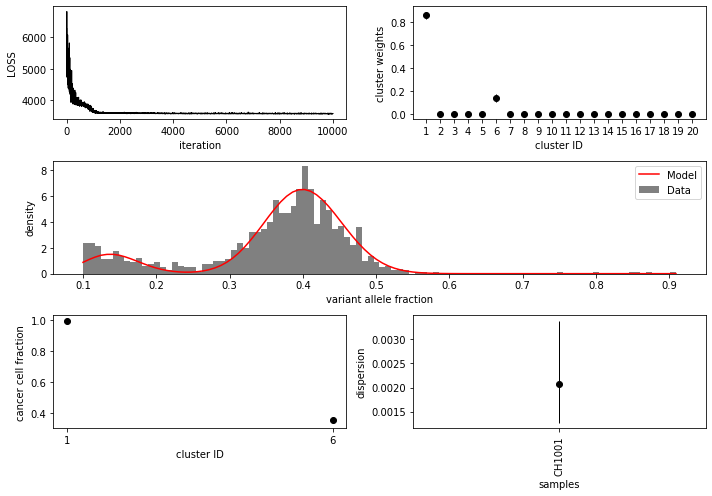

In [6]:
pmc.tt_rng(42)    ## for reproducibility
RES = cln.infer(DATA, 
                model_args={'threshold': 0.05},
                pymc3_args={'niters': int(10e3)})
cln.viz.plot_summary(RES, figsize=(10, 7));

That's better. By using the argument `'threshold': 0.05`, we force the algorithm to ignore clusters with weights less than 5%. This is a simple trick you can use to remove spurious clusters.   

Internally, `clonosGP` uses a *beta binomial* model by default to account for potential over-dispersion in the data. In the bottom-right panel, you can see the estimated dispersion parameter (median and 95% credible intervals). The dispersion is rather small, so we might be able to use a simple binomial model instead. Let's do this: 

INFO:clonosGP:No CNm column in the data. Multiplicity values will be approximated.
Average Loss = 3,578.9: 100%|██████████| 10000/10000 [00:17<00:00, 583.26it/s]
Finished [100%]: Average Loss = 3,578.9
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 3,578.9
INFO:clonosGP:Calculating posterior cluster weights and centres.
INFO:clonosGP:Calculating posterior CCF values.
INFO:clonosGP:Calculating posterior predictive distribution.
INFO:clonosGP:Finished.


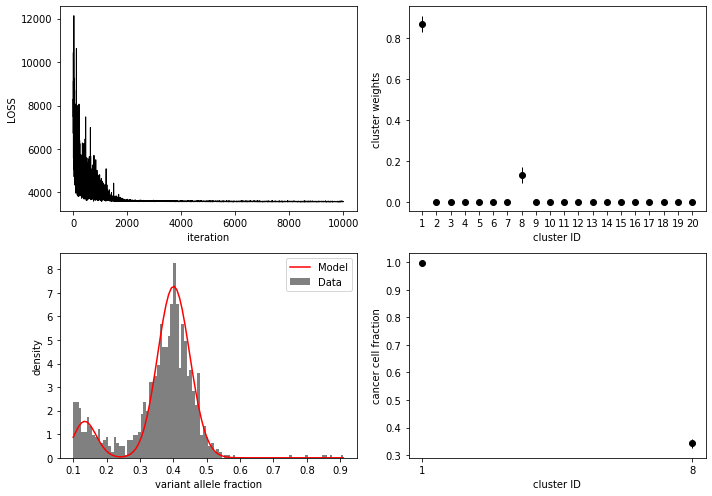

In [7]:
pmc.tt_rng(42)    ## for reproducibility
RES2 = cln.infer(DATA, 
                 model_args={'threshold': 0.05, 'lik': 'Bin'},    # 'BBin' is the default (for beta binomial)
                 pymc3_args={'niters': int(10e3)})
cln.viz.plot_summary(RES2, figsize=(10, 7));

So, we get effectively the same results with either a binomial or a beta binomial model. Let's inspect these results in more detail:     

In [8]:
RES['data']

,SAMPLEID,PURITY,MUTID,r,R,CNn,CNt,CNm,VAF,VAF0,CCF_,CCF,CCF_HI,CCF_LO,PPD,PPD_HI,PPD_LO,CLUSTERID
0,CH1001,0.8,chr10:100797870:G:A,28.0,120.0,2.0,2.0,1.0,0.233333,0.4,0.583333,0.356965,0.998596,0.335451,0.095389,0.164813,0.054153,6
1,CH1001,0.8,chr10:10219642:T:A,43.0,83.0,2.0,2.0,1.0,0.518072,0.4,1.000000,0.996722,0.999051,0.989539,0.733183,0.844136,0.632034,1
2,CH1001,0.8,chr10:106318358:C:T,42.0,125.0,2.0,2.0,1.0,0.336000,0.4,0.840000,0.996722,0.999051,0.989539,3.168858,3.437897,2.965079,1
3,CH1001,0.8,chr10:108262841:T:A,43.0,86.0,2.0,2.0,1.0,0.500000,0.4,1.000000,0.996722,0.999051,0.989539,1.259767,1.394292,1.114106,1
4,CH1001,0.8,chr10:109677868:G:A,49.0,113.0,2.0,2.0,1.0,0.433628,0.4,1.000000,0.996722,0.999051,0.989539,5.198456,5.487320,4.874698,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,CH1001,0.8,chr9:89638811:A:G,39.0,89.0,2.0,2.0,1.0,0.438202,0.4,1.000000,0.996722,0.999051,0.989539,4.651673,4.900375,4.382079,1
996,CH1001,0.8,chr9:91277028:G:T,46.0,118.0,2.0,2.0,1.0,0.389831,0.4,0.974576,0.996722,0.999051,0.989539,6.717605,7.128707,6.259863,1
997,CH1001,0.8,chr9:91498649:G:T,45.0,108.0,2.0,2.0,1.0,0.416667,0.4,1.000000,0.996722,0.999051,0.989539,6.100459,6.465886,5.722863,1
998,CH1001,0.8,chr9:96000526:G:A,42.0,108.0,2.0,2.0,1.0,0.388889,0.4,0.972222,0.996722,0.999051,0.989539,6.465415,6.849619,6.047689,1


`clonosGP` returns part of the original data matrix with additional columns attached: 
1. `CLUSTERID` returns the most likely cluster assigment. Mutations with the same `CLUSTERID` were assigned to the same cluster.
2. Columns `CCF`, `CCF_HI` and `CCF_LO` are the estimated median *cancer cell fraction* (CCF) along with 95% *credible intervals*. Notice that if `PURITY` is not provided by the user, it is assumed to be 100%. In this case, CCF should be interpreted as the *cellular prevalence* of the mutation (i.e. the fraction of cells harbouring the mutation in the mixture of both normal and cancer cells), not as the cancer cell fraction. `CCF_` is a first, rough estimate of CCF.
3. `PPD`, `PPD_HI`, `PPD_LO` are the median *posterior predictive distribution* and 95% credible intervals, resepctively.
4. `VAF` is the *variant allele fraction* of the mutation, calculated as `r/R`; `VAF0` would be the expected VAF if the mutation was clonal (i.e. if the mutation had CCF=1).
5. `CNm` is the estimated multiplicity for each mutation in each sample

## Processing multiple longitudinal samples

The presence of a `TIME` column in your data indicates a longitudinal dataset. Let's see an example:

In [9]:
DATA = pnd.read_csv('data/cll_Schuh_2012_CLL003.csv')

The data must not contain missing values. It is also important that each mutation is covered (i.e. `R>0`) in each sample, although it may not be present (i.e. `r>0`) in all samples. You can check whether this is the case by reshaping the dataset as follows: 

In [10]:
DATA.pivot_table(index='MUTID', columns=['SAMPLEID', 'TIME'], values=['r', 'R'])

R                   r                
SAMPLEID   a   b   c   d   e   a   b   c   d   e
TIME      0   19  25  31  35  0   19  25  31  35
MUTID                                           
M1        38  48  29  37  42  22  18  11  20  23
M10       39  34  41  50  35   0   0   6  19  12
M11       38  34  34  44  35  16  15   2   0   0
M12       46  33  44  49  32  16  13  17  34  15
M13       31  37  26  48  33  19  20   8  29  18
M14       42  45  46  22  25  15  18   2   1   0
M15       31  28  39  34  27  18  13  14  16  12
M16       46  37  35  42  28   2   0   6  19  13
M17       54  27  39  45  37  20  12   2   0   0
M18       46  30  34  47  33  25  13  14  25  20
M19       39  28  40  34  32   0   0  10  12  14
M2        33  30  40  46  25   9  16   3   0   0
M20       42  30  40  35  32   0   0  11  12  14
M21       42  34  33  53  32   0   0   6  27  19
M22       45  37  40  44  23  20  18   3   0   0
M23       43  33  28  38  29  21  17  15  16  13
M24       58  47  45  49  58   5   2   6  24  36
M25       44  33  35  44  32  22  21  10  18  19
M26       50  32  31  43  23  28  19   6  19  10
M27       36  43  42  64  41  20  25  16  32  27
M28       27  20  17  20  16   0   0   8  18  16
M3        43  38  35  40  44  19  17   2   0   0
M4        40  40  31  40  35   1   2  13  27  17
M5        37  19  25  26  19  31  16   1   0   0
M6        57  51  52  54  24  24  27   3   0   0
M7        26  32  40  47  33   0   0   9  20  14
M8        24  21  23  23  26   9   7   4  10   9
M9        40  32  35  47  27  17  14   3   0   0

As you can see, `R` is non-zero for all mutations in all samples, but `r` is allowed to be zero in some samples. Now, we are ready to process the data:

INFO:clonosGP:No PURITY column in the data. Assuming all samples have purity 100%.
INFO:clonosGP:No CNn column in the data. Assuming germline is diploid over all provided loci.
INFO:clonosGP:No CNt column in the data. Assuming all tumour samples are diploid over all provided loci.
INFO:clonosGP:No CNm column in the data. Multiplicity values will be approximated.
Average Loss = 362.09: 100%|██████████| 10000/10000 [00:07<00:00, 1272.84it/s]
Finished [100%]: Average Loss = 362.05
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 362.05
INFO:clonosGP:Calculating posterior cluster weights and centres.
INFO:clonosGP:Calculating posterior CCF values.
INFO:clonosGP:Calculating posterior predictive distribution.
INFO:clonosGP:Calculating GP-related quantities.
INFO:clonosGP:Finished.


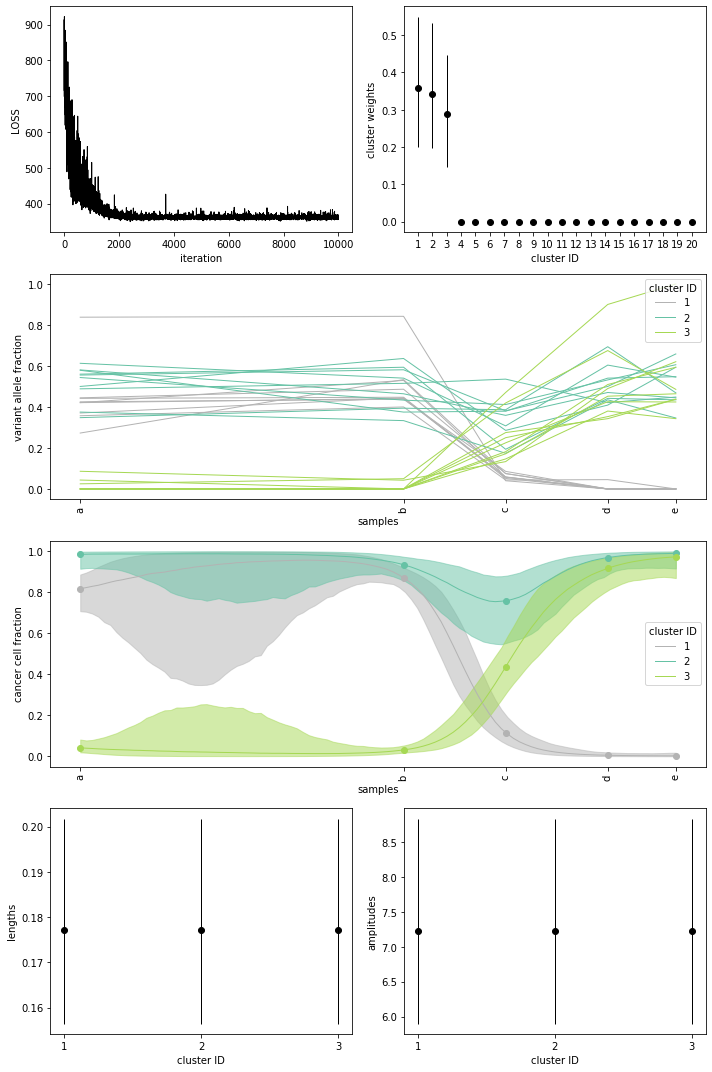

In [11]:
DATA = pnd.read_csv('data/cll_Schuh_2012_CLL003.csv')

pmc.tt_rng(42)    ## for reproducibility
RES = cln.infer(DATA, 
                model_args={'prior': 'GP0', 'cov': 'Mat32', 'lik': 'Bin', 'threshold': 0.05},
                pymc3_args={'niters': int(10e3)})
cln.viz.plot_summary(RES, figsize=(10, 15));

When processing longitudinal data, we estimate CCF values not only *at* the collection time points (a,b c, etc.), but also *between* them (along with uncertainty estimates). Instead of `GP0`, you can also use `GP1`, `GP2` or `GP3` priors, which correspond to models of increasing complexity (see original paper for details). Furthermore, for each choice of `prior`, you can use any of the following `cov` choices (i.e. covariance kernels) in terms of increasing smoothness: `Exp`, `Mat32`, `Mat52` or `ExpQ`. Finally, you can set the prior to `Flat`, in which case `cov` is ingored and the `TIME` column is only used for plotting.

You can see that the algorithm has converged nicely (top-left panel) and three clusters were identified (two middle panels). The estimated  amplitudes and time scales of the selected covariance kernel for each identified cluster are shown in the bottom panels. 
 
You can also check the fitted model against the actual data:

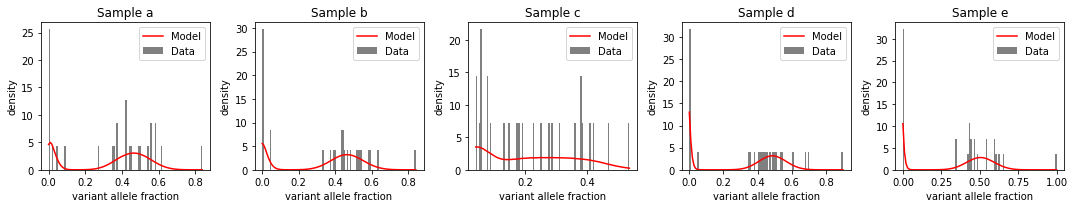

In [12]:
cln.viz.plot_samples(RES, figsize=(15, 3), ncols=5, samples=['a', 'b', 'c', 'd', 'e']);

## Processing multiple cross-sectional samples

If there are multiple samples in your data, but no `TIME` column, then the samples are assumed to be cross-sectional.

INFO:clonosGP:No PURITY column in the data. Assuming all samples have purity 100%.
INFO:clonosGP:Multiple samples detected in the data, but there is no TIME column. Assuming data is cross-senctional.
INFO:clonosGP:No CNn column in the data. Assuming germline is diploid over all provided loci.
INFO:clonosGP:No CNt column in the data. Assuming all tumour samples are diploid over all provided loci.
INFO:clonosGP:No CNm column in the data. Multiplicity values will be approximated.
Average Loss = 374.83: 100%|██████████| 10000/10000 [00:04<00:00, 2302.80it/s]
Finished [100%]: Average Loss = 374.84
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 374.84
INFO:clonosGP:Calculating posterior cluster weights and centres.
INFO:clonosGP:Calculating posterior CCF values.
INFO:clonosGP:Calculating posterior predictive distribution.
INFO:clonosGP:Finished.


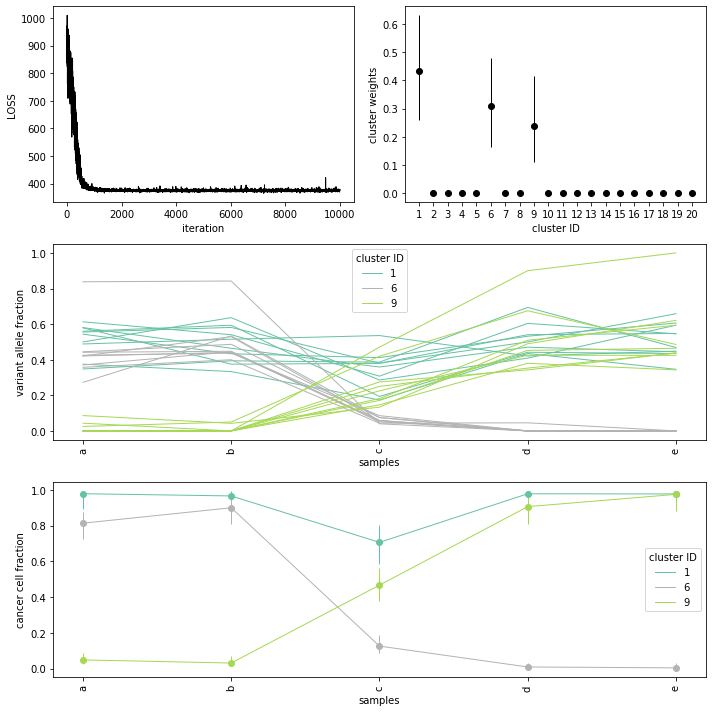

In [13]:
DATA = pnd.read_csv('data/cll_Schuh_2012_CLL003.csv').drop('TIME', axis=1)  # remove TIME column

pmc.tt_rng(42)    ## for reproducibility
RES = cln.infer(DATA,
                model_args={'lik': 'Bin', 'threshold': 0.05},
                pymc3_args={'niters': int(10e3)})
cln.viz.plot_summary(RES, figsize=(10, 10));

**This is the end of this tutorial**